In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
#Open drugreview files
df_train=pd.read_csv("drugsComTrain_raw.csv")
print("Train Data format " ,df_train.head())
print("Train Data shape ",df_train.shape)
print("Condition count in Train dataset ", df_train['condition'].value_counts())
df_train_cond_rev=df_train[['condition','review']].copy()
df_temp=df_train_cond_rev[pd.notnull(df_train_cond_rev['review'])]
df_train_fil=df_temp[pd.notnull(df_temp['condition'])]
print("Dataset with columns Condition and review" , df_train_fil)
print("Dataset with columns Condition and review dimension " ,df_train_fil.shape)

Train Data format     uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37  
T

Text(0.5, 1.0, 'Top20 : The number of reviews per condition.')

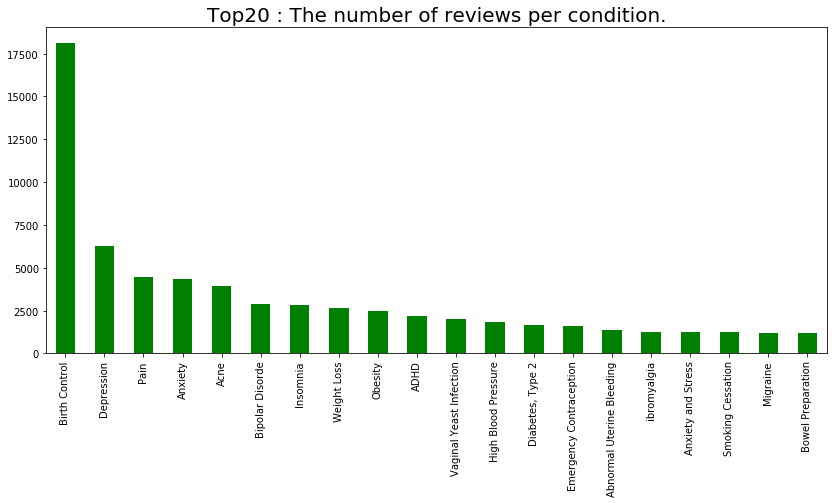

In [3]:
# Data plot based on review and condition
condition_rev = df_train_fil.groupby(['condition'])['review'].nunique().sort_values(ascending=False)
condition_rev[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of reviews per condition.", fontsize = 20)

In [4]:
df_train_fil[df_train_fil['condition']=='3</span> users found this comment helpful.'].head(3)

,condition,review
243,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a..."
1864,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute..."
3322,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t..."


In [5]:
df_comment = df_train_fil[df_train_fil['condition'].str.contains('comment')]
df_comment

,condition,review
105,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f..."
196,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p..."
243,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a..."
264,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con..."
391,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger..."
...,...,...
160322,99</span> users found this comment helpful.,"""Great pill... You can definitely see it worki..."
160791,62</span> users found this comment helpful.,"""I am sharing a painful experience actually. T..."
160899,7</span> users found this comment helpful.,"""I&#039;ve been taking Geodon for about a mont..."
160921,92</span> users found this comment helpful.,"""At 300mg 4x daily my pain was almost gone. """


In [6]:
# Dropping rows that contain incorrect information 

df_train_fil = df_train_fil[~df_train_fil['condition'].str.contains('comment')]
print(df_train_fil.shape)

(159498, 2)


In [7]:
df_train_fil.condition.nunique()

811

In [8]:
df_train_fil.head()

,condition,review
0,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati..."
1,ADHD,"""My son is halfway through his fourth week of ..."
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
4,Opiate Dependence,"""Suboxone has completely turned my life around..."


In [9]:
df_train_fil.describe()

,condition,review
count,159498,159498
unique,811,111210
top,Birth Control,"""Good"""
freq,28788,33


In [10]:
# Displaying number of reviewed drugs by condition

ds_reviews_per_condition = df_train_fil.groupby('condition').agg({'review':'count'})
ds_reviews_per_condition = ds_reviews_per_condition.sort_values(by='review', ascending=False)#[0:20]
ds_reviews_per_condition = ds_reviews_per_condition.reset_index()
print("Top 25 Conditions are :" ,ds_reviews_per_condition.head(25))

Top 25 Conditions are :                     condition  review
0               Birth Control   28788
1                  Depression    9069
2                        Pain    6145
3                     Anxiety    5904
4                        Acne    5588
5             Bipolar Disorde    4224
6                    Insomnia    3673
7                 Weight Loss    3609
8                     Obesity    3568
9                        ADHD    3383
10           Diabetes, Type 2    2554
11    Emergency Contraception    2463
12        High Blood Pressure    2321
13    Vaginal Yeast Infection    2274
14  Abnormal Uterine Bleeding    2096
15          Bowel Preparation    1859
16                ibromyalgia    1791
17          Smoking Cessation    1780
18                   Migraine    1694
19         Anxiety and Stress    1663
20   Major Depressive Disorde    1607
21               Constipation    1595
22              Panic Disorde    1463
23               Chronic Pain    1455
24        Migraine Prevent

In [11]:
df_train_fil.condition.value_counts()

Birth Control                              28788
Depression                                  9069
Pain                                        6145
Anxiety                                     5904
Acne                                        5588
                                           ...  
Hyperuricemia Secondary to Chemotherapy        1
Stomach Cance                                  1
Multiple Endocrine Adenomas                    1
Neutropenia                                    1
Thyroid Suppression Test                       1
Name: condition, Length: 811, dtype: int64

In [12]:
value_counts=df_train_fil['condition'].value_counts()
# Select the values where the count is less than 3 (or 5 if you like)
to_remove = value_counts[value_counts <= 500].index
# Keep rows where the city column is not in to_remove
df_train_fil = df_train_fil[~df_train_fil.condition.isin(to_remove)]
df_train_fil.shape
df_train_fil.condition.value_counts()

Birth Control                   28788
Depression                       9069
Pain                             6145
Anxiety                          5904
Acne                             5588
Bipolar Disorde                  4224
Insomnia                         3673
Weight Loss                      3609
Obesity                          3568
ADHD                             3383
Diabetes, Type 2                 2554
Emergency Contraception          2463
High Blood Pressure              2321
Vaginal Yeast Infection          2274
Abnormal Uterine Bleeding        2096
Bowel Preparation                1859
ibromyalgia                      1791
Smoking Cessation                1780
Migraine                         1694
Anxiety and Stress               1663
Major Depressive Disorde         1607
Constipation                     1595
Panic Disorde                    1463
Chronic Pain                     1455
Migraine Prevention              1413
Urinary Tract Infection          1316
Muscle Spasm

In [13]:
df2_train=df_train_fil
#df2_train = df_train_fil.sample(50000).copy()

In [14]:
# Create a new column 'category_id' with encoded categories 
df2_train['condition_id'] = df2_train['condition'].factorize()[0]
category_id_df = df2_train[['condition', 'condition_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['condition_id', 'condition']].values)

# New dataframe
df2_train.head()

,condition,review,condition_id
1,ADHD,"""My son is halfway through his fourth week of ...",0
2,Birth Control,"""I used to take another oral contraceptive, wh...",1
3,Birth Control,"""This is my first time using any form of birth...",1
4,Opiate Dependence,"""Suboxone has completely turned my life around...",2
5,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",3


In [15]:
'''def print_plot(index):
    example = df2_train[df2_train.index == index][['condition', 'review']].values[0]
    if len(example) > 0:
        print(example[1])
        print('Condition:', example[0])

print_plot(0)
print_plot(2)
print_plot(6)'''

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
#Clean review comments
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z00-99 #+_]')
add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\','this','will','doctor','took','got','month','an','weight','if','one','week','when','more','are','weeks','are','would','just','feel','day',
 'im','though','daily','found','daily','found','give','7','gained','happy','sure','told','less','gave','three',
 'side',
 'taking',
 'ive',
 'years',
 'first',
 'effects',
 'take',
 'started',
 'like',
 'months',
 'get',
 'days',
 'time',
 '2',
 'feel',
 'would',
 '3',
 'back', 'also',
 'dont',
 'since', 'also',
 'dont',
 'since', 'cant',
 'stop',
 'morning',
 'however',
 'taken',
 'within',
 'see''good',
 'night',
 'even',
 'year',
 'great',
 'ago',
 '4',
 'tried',
 'little',
 '5',
 'dose',
'used',
 'worked',
 '1',
 'getting',
 'could',
 '10',
 'almost',
 'put',
 '6',
 'use',
 'nothing',
 'far',
'helped',
 'normal',
'gain',
 'recommend',
 'without',
 'long',
'thing',
 'make',
'many',
 'noticed','said','ood',
 'best',
 'thought',
 'gone',
 'working',
 'couldnt',
 'anything',
 'something',
 'spotting',
 'things',
 'people',
 'second',
 'need',
 '20',
 'way',
 'half',
 'start',
 'another',
 'completely',
 'wasnt',
 'everything',
 '8',
 'face',
 'bit',
 'high',
 'worth',
 'definitely',
 'pretty',
 'decided',
 'actually',
 'lbs',
 'effective',
 'past',
 'today',
 'helps',
 'heavy',
 'new',
 'may',
 'doesnt',
 '30',
 'minutes',
 '15',
 'problem',
 'dry',
 'came',
 'reviews',
 'shot',
 'issues',
 'trying',
 'switched',
 'depressed',
 '12',
 'full',
 'sometimes',
 'find',
 'meds',
 'change',
 'anyone',
 'caused',
 'thats',
 'results',
 'done',
 'increased',
 'twice',
 'energy',
 'fine',
 'several',
 'hard',
 'read',
 'given',
 'pressure',
 'come',
 'clear',
 'eating',
 'already',
 'insurance',
 'everyone',
 'dosage',
 'mouth',
 'amazing',
 'id',
 'enough',
 'wanted',
 'overall',
 'maybe',
 'began','really',
 'still',
 'never',
 'much',
 'work',
 'went',
'two',
 'didnt',
'go',
'made',
 'works',
 'going',
 'mg',
 'hours',
 'last',
'ever',
 'lost',
'lot',
 'try',
 'think',
'stopped',
 'away',
 'know',
 'times',
'always',
 'havent',
 'next',
'due',
 'want',
 'around',
 'experienced',
 'finally',
'able',
 'right',
 'later',
 'different',
'hour',
 'keep',
 'dr',
 'changed',
 'makes',
'least',
 'else',
'difference',
 'seems',
 'needed',
 'product',
 'point',
 'soon',
 'absolutely',
 'anymore',
 'usually',
'drink',
 'free',
 'stay',
 'became',
 'recently',
 'awful',
'small',
 'hoping',
 'believe']

STOPWORDS = set(stopwords.words('english'))
stop_words=STOPWORDS.union(add_stop)
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text
    
df2_train['review'] = df2_train['review'].apply(clean_text)
#print_plot(10)
df2_train


,condition,review,condition_id
1,ADHD,son halfway fourth intuniv concerned highest h...,0
2,Birth Control,oral contraceptive 21 pill cycle light periods...,1
3,Birth Control,using form birth control glad patch decreased ...,1
4,Opiate Dependence,suboxone turned life healthier excelling job m...,2
5,Benign Prostatic Hyperplasia,2nd 5mg rock erections experianced headache lo...,3
...,...,...,...
161290,High Blood Pressure,tekturna 9 effect immediate calcium channel bl...,37
161291,Birth Control,junel birth control mood swings previous birth...,1
161293,Nausea/Vomiting,iv surgey immediately anxious sit pa oh yes ha...,55
161294,Rheumatoid Arthritis,limited improvement developed bad rash md refu...,14


In [17]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
reviews = df2_train.review.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:200]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anoopsharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


62157


['pain',
 'pill',
 'period',
 'medication',
 'anxiety',
 'bad',
 'life',
 'control',
 'better',
 'felt',
 'every',
 'good',
 'well',
 'medicine',
 'acne',
 'birth',
 'sleep',
 'depression',
 'drug',
 'mood',
 'prescribed',
 'periods',
 'sex',
 'help',
 'severe',
 'bleeding',
 'feeling',
 'cramps',
 'skin',
 'nausea',
 'experience',
 'using',
 'effect',
 'pills',
 'worse',
 'old',
 'symptoms',
 'body',
 'horrible',
 'see',
 'love',
 'pounds',
 'headaches',
 'blood',
 'eat',
 'swings',
 'stomach',
 'problems',
 'panic',
 'drive',
 'couple',
 'worst',
 'light',
 'pregnant',
 'appetite',
 'starting',
 'terrible',
 'tired',
 'cramping',
 'painful',
 'loss',
 'extremely',
 'longer',
 'water',
 'migraines',
 'relief',
 'hope',
 'bed',
 'attacks',
 'insertion',
 'low',
 'headache',
 'diagnosed',
 'inserted',
 'mild',
 'ill',
 'sick',
 'insomnia',
 'negative',
 'infection',
 'lose',
 'mirena',
 'plan',
 'med',
 'extreme',
 'lexapro',
 'major',
 'food',
 'whole',
 'crazy',
 '9',
 'medications',


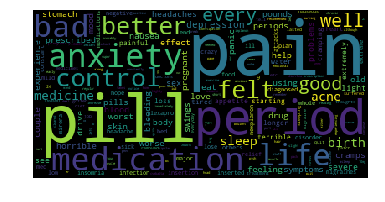

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [20]:
df2_train.review.describe()


count     128477
unique     87988
top             
freq         426
Name: review, dtype: object

In [21]:
plt.close("all")
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10,
                        ngram_range=(1, 1), 
                        stop_words='english')

# We transform each review into a vector
features = tfidf.fit_transform(df2_train.review).toarray()
#dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

labels = df2_train.condition_id

print("Each of the %d review is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 128477 review is represented by 11965 features (TF-IDF score of unigrams and bigrams)


In [22]:
df2_train.shape
plt.close('all')
print(features)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  #trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  #bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  onegrams = [v for v in feature_names if len(v.split(' ')) == 1]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated onegrams are: %s" %(', '.join(onegrams[-N:])))
  #print("  * Most Correlated bigrams are: %s" %(', '.join(bigrams[-N:])))


==> ADHD:
  * Most Correlated onegrams are: adderall, vyvanse, adhd

==> Abnormal Uterine Bleeding:
  * Most Correlated onegrams are: mirena, depo, bleeding

==> Acne:
  * Most Correlated onegrams are: epiduo, skin, acne

==> Allergic Rhinitis:
  * Most Correlated onegrams are: allegra, zyrtec, allergies

==> Anxiety:
  * Most Correlated onegrams are: buspar, xanax, anxiety

==> Anxiety and Stress:
  * Most Correlated onegrams are: citalopram, anxiety, celexa

==> Asthma, Maintenance:
  * Most Correlated onegrams are: advair, inhaler, asthma

==> Back Pain:
  * Most Correlated onegrams are: pain, relafen, norco

==> Bacterial Infection:
  * Most Correlated onegrams are: bacterial, infection, flagyl

==> Bacterial Vaginitis:
  * Most Correlated onegrams are: vaginitis, metronidazole, bv

==> Benign Prostatic Hyperplasia:
  * Most Correlated onegrams are: bph, rapaflo, flomax

==> Bipolar Disorde:
  * Most Correlated onegrams are: latuda, lamictal, bipolar

==> Birth Control:
  * Most C

In [ ]:
X = df2_train['review'] # Collection of documents
y = df2_train['condition'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

#5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/anoopsharma/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anoopsharma/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2_train.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

In [ ]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))
'''print(metrics.classification_report(y_test, y_pred, 
             target_names= df2_train['condition'].unique()))'''

In [ ]:
y_train

In [ ]:
y_pred

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.condition.values, 
            yticklabels=category_id_df.condition.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)

In [ ]:
print(conf_mat)

In [ ]:
df2_train.condition.value_counts()

In [ ]:
df2_train.condition.value_counts()

In [ ]:
df2_train.review[1]